In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
import utils

In [2]:
(inc_df, pop_df) = utils.get_datafiles()

In [3]:
inc_df.head()

,WHO_REGION,ISO_code,Cname,Disease,2018,2017,2016,2015,2014,2013,...,1989,1988,1987,1986,1985,1984,1983,1982,1981,1980
0,EMR,AFG,Afghanistan,measles,2012.0,1511.0,638.0,1154.0,492.0,430.0,...,1170.0,4561.0,10357.0,8107.0,14457.0,16199.0,18808.0,20320.0,31107.0,32455.0
1,EUR,ALB,Albania,measles,1469.0,12.0,17.0,NaN,NaN,0.0,...,136034.0,0.0,0.0,0.0,0.0,0.0,17.0,3.0,NaN,NaN
2,AFR,DZA,Algeria,measles,3356.0,112.0,41.0,63.0,0.0,25.0,...,4169.0,2634.0,2500.0,3975.0,20114.0,22553.0,22126.0,29584.0,20849.0,15527.0
3,EUR,AND,Andorra,measles,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AFR,AGO,Angola,measles,57.0,29.0,53.0,119.0,11699.0,8523.0,...,19820.0,21009.0,13368.0,15580.0,22822.0,22685.0,22589.0,30067.0,19714.0,29656.0


In [4]:
# rename column to match
tmp = pop_df
tmp = pop_df.rename({'Country Code': 'ISO_code'}, axis=1)
# lookup table 
df = pd.merge(tmp, inc_df, on='ISO_code')
all_cols = df.columns
keep_cols = {'Cname', 'ISO_code', 'WHO_REGION', 'Country Name'}
drop_cols = []
for c in all_cols:
    if c not in keep_cols:
        drop_cols.append(c)
df.drop(drop_cols,axis=1,inplace=True)
df.head()

,Country Name,ISO_code,WHO_REGION,Cname
0,Afghanistan,AFG,EMR,Afghanistan
1,Angola,AGO,AFR,Angola
2,Albania,ALB,EUR,Albania
3,Andorra,AND,EUR,Andorra
4,United Arab Emirates,ARE,EMR,United Arab Emirates (the)


In [5]:
# https://apps.who.int/medicinedocs/en/d/Js2297e/2.html
# EMR: Eastern Mediterranean, AFR: African, EUR: European, SEAR: South-East Asia, WPR: Western Pacific, AMR: Americas
df['WHO_REGION'].unique()

array(['EMR', 'AFR', 'EUR', 'AMR', 'WPR', 'SEAR'], dtype=object)

In [6]:
# loop through ISO code and calculate mean incidence and CV for specific year
years = [1990, 2014]
regions = ['AMR', 'AFR']
# years = [1990]
# regions = ['AMR']
res_dict = {}
# loop over regions
for region in regions:
    res_dict.update({region:{}})
    df_ = df[df['WHO_REGION'] == region]
    res = {}
    cname = []
    # loop over countries in the region
    for index,row in df_.iterrows():
        # country name by ISO code
        cname.append(row['ISO_code'])
        # get the data
        (cases,pop,time) = utils.get_cases_pop(row['ISO_code'], inc_df, pop_df)
        # calculate CV
        cv, cvt = utils.calc_cv(cases, pop, time)
        # calculate MI
        mi, mit = utils.calc_wmi(cases, pop, time)
        for y in years:
            if str(y)+'_cv' not in res.keys():
                res.update({str(y)+'_cv':list(cv[cvt == y])})
                res.update({str(y)+'_mi':list(mi[mit == y])})
            else:
                res[str(y)+'_cv'].append(cv[cvt == y][0])
                res[str(y)+'_mi'].append(mi[mit == y][0])
    # save dictionary by region
    res.update({'ISO_code':cname})
    res_dict[region] = pd.DataFrame.from_dict(res)

C:\Users\krosenfeld\Documents\projects\measles\CanonicalPathTools\utils.py:91: RuntimeWarning: invalid value encountered in double_scalars
  wcv[ix] = np.sqrt(num / den) / wmi


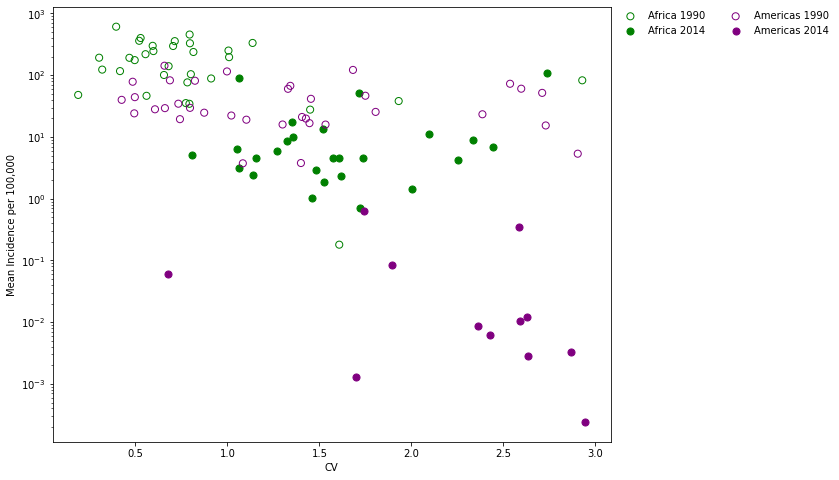

In [7]:
afr_col = 'green'
amr_col = 'purple'
ms = 50
plt.figure(figsize=(10,8))
plt.scatter(res_dict['AFR']['1990_cv'],res_dict['AFR']['1990_mi'],
            ms,marker='o',edgecolor=afr_col,facecolors='none',label='Africa 1990')
plt.scatter(res_dict['AFR']['2014_cv'],res_dict['AFR']['2014_mi'],
            ms,marker='o',edgecolor=afr_col,facecolors=afr_col,label='Africa 2014')
plt.scatter(res_dict['AMR']['1990_cv'],res_dict['AMR']['1990_mi'],
            ms,marker='o',edgecolor=amr_col,facecolors='none',label='Americas 1990')
plt.scatter(res_dict['AMR']['2014_cv'],res_dict['AMR']['2014_mi'],
            ms,marker='o',edgecolor=amr_col,facecolors=amr_col,label='Americas 2014')

plt.yscale('log')
plt.xlabel('CV')
plt.ylabel('Mean Incidence per 100,000')
# plt.legend()
ax = plt.gca()
ax.legend(loc='upper left', bbox_to_anchor= (1.01, 1), ncol=2, 
            borderaxespad=0, frameon=False)
plt.savefig('Fig1.png',transparent=True)